# Exploratory Data Analysis

## Imports and constants

In [2]:
%load_ext autoreload
%autoreload 2

import os
from typing import Dict, Any
import logging 

logging.basicConfig(
     level=logging.INFO, 
     format= '[%(asctime)s|%(levelname)s|%(module)s.py:%(lineno)s] %(message)s',
     datefmt='%H:%M:%S'
 )
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
# Create new `pandas` methods which use `tqdm` progress
# (can use tqdm_gui, optional kwargs, etc.)
tqdm.pandas()
from transformers import AutoTokenizer
from datasets import load_dataset

from defi_textmine_2025.data import (
    load_labeled_raw_data,
    load_test_raw_data,
    clean_raw_dataset,
    print_value_types,
    save_data,
    TextToMultiLabelDataGenerator,
)
from defi_textmine_2025.data import TARGET_COL, INPUT_COLS, INTERIM_DIR, EDA_DIR

VALIDATION_RATE = 0.25
checkpoint = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

def count_tokens(text: str) -> int:
    return len(tokenizer(text)["input_ids"])

[03:40:41|INFO|config.py:58] PyTorch version 2.3.1 available.
[03:40:41|INFO|config.py:105] TensorFlow version 2.16.2 available.
/home/tagny/.pyenv/versions/3.11.8/envs/kgl11/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


## Loading data

In [3]:
labeled_raw_df = load_labeled_raw_data()
labeled_raw_df

,text,entities,relations
id,,,
181,"Anam Destresse, président de l'ONG ""Ma passion...","[{""id"": 0, ""mentions"": [{""value"": ""accident"", ...","[[0, ""STARTED_IN"", 9], [7, ""IS_LOCATED_IN"", 9]..."
31669,"À Paris, le 8 avril 2022, l'usine de déodorant...","[{""id"": 0, ""mentions"": [{""value"": ""explosé"", ""...","[[9, ""IS_LOCATED_IN"", 8], [11, ""OPERATES_IN"", ..."
51470,"En Espagne, dans une région agricole, une cont...","[{""id"": 0, ""mentions"": [{""value"": ""contaminati...","[[7, ""IS_PART_OF"", 8], [9, ""OPERATES_IN"", 1], ..."
51332,Un important incendie a fait des ravages dans ...,"[{""id"": 0, ""mentions"": [{""value"": ""incendie"", ...","[[12, ""IS_IN_CONTACT_WITH"", 5], [0, ""IS_LOCATE..."
1131,« Je coule » : onze heures après avoir envoyé ...,"[{""id"": 0, ""mentions"": [{""value"": ""renversé"", ...","[[9, ""IS_LOCATED_IN"", 2], [0, ""START_DATE"", 17..."
...,...,...,...
1288,"M. Thibault Alekseï, membre de l'association ""...","[{""id"": 0, ""mentions"": [{""value"": ""perdu le co...","[[2, ""IS_PART_OF"", 3], [12, ""IS_IN_CONTACT_WIT..."
3822,Des employés d'une usine de production médical...,"[{""id"": 0, ""mentions"": [{""value"": ""grève"", ""st...","[[8, ""HAS_CONTROL_OVER"", 7], [4, ""HAS_CATEGORY..."
51266,"Le 13 mars 2001, Belgrade a connu un krach bou...","[{""id"": 0, ""mentions"": [{""value"": ""krach bours...","[[1, ""STARTED_IN"", 3], [10, ""IS_PART_OF"", 4], ..."


In [4]:
test_raw_df = load_test_raw_data()
test_raw_df

,text,entities
id,,
1204,“FEAR” est une organisation spécialisée dans l...,"[{""id"": 0, ""mentions"": [{""value"": ""crash"", ""st..."
4909,"48 heures après le braquage du ""DC Supermarket...","[{""id"": 0, ""mentions"": [{""value"": ""DC Supermar..."
2353,"À Genève, la boîte de nuit ""Pretty Woman"" a en...","[{""id"": 0, ""mentions"": [{""value"": ""tombé"", ""st..."
1210,"À Caracas, l'an dernier, une mine située à l'o...","[{""id"": 0, ""mentions"": [{""value"": ""effondremen..."
41948,"À Genève, une industrie de fabrication d'arbre...","[{""id"": 0, ""mentions"": [{""value"": ""incendiée"",..."
...,...,...
51452,"Le WOOP, une organisation mondiale, avait prop...","[{""id"": 0, ""mentions"": [{""value"": ""épidémie"", ..."
51491,"Madame Pautrat Elina, dirigeante de l’associat...","[{""id"": 0, ""mentions"": [{""value"": ""pollution"",..."
51492,"Monsieur Elirone Trameur, membre de l’associat...","[{""id"": 0, ""mentions"": [{""value"": ""pollution"",..."


## Analysing raw data

### Check value types

In [5]:
labeled_raw_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 800 entries, 181 to 124
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text       800 non-null    object
 1   entities   800 non-null    object
 2   relations  800 non-null    object
dtypes: object(3)
memory usage: 25.0+ KB


In [6]:
test_raw_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 400 entries, 1204 to 51742
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   text      400 non-null    object
 1   entities  400 non-null    object
dtypes: object(2)
memory usage: 9.4+ KB


In [7]:
# types of values in train data
print_value_types(labeled_raw_df)

text <class 'str'>
entities <class 'str'>
relations <class 'str'>


In [8]:
# types of values in test data
print_value_types(test_raw_df)

text <class 'str'>
entities <class 'str'>


### Check for duplicated rows

In [9]:
labeled_raw_df[labeled_raw_df.duplicated()]

,text,entities,relations
id,,,


In [10]:
test_raw_df[test_raw_df.duplicated()]

,text,entities
id,,


### Check for missing values

In [11]:
labeled_raw_df.isnull().sum()

text         0
entities     0
relations    0
dtype: int64

In [12]:
test_raw_df.isnull().sum()

text        0
entities    0
dtype: int64

In [13]:
labeled_raw_df.relations.sort_values()

id
41601    [[0, "DEATHS_NUMBER", 14], [3, "RESIDES_IN", 4...
2514     [[0, "END_DATE", 11], [0, "IS_LOCATED_IN", 4],...
1223     [[0, "END_DATE", 11], [10, "START_DATE", 11], ...
2329     [[0, "END_DATE", 11], [4, "RESIDES_IN", 1], [0...
3898     [[0, "END_DATE", 9], [5, "OPERATES_IN", 7], [1...
                               ...                        
4964     [[9, "IS_LOCATED_IN", 5], [8, "OPERATES_IN", 5...
41071    [[9, "IS_LOCATED_IN", 5], [9, "IS_LOCATED_IN",...
31669    [[9, "IS_LOCATED_IN", 8], [11, "OPERATES_IN", ...
41918    [[9, "IS_LOCATED_IN", 8], [13, "HAS_CONTROL_OV...
155      [[9, "OPERATES_IN", 1], [0, "IS_LOCATED_IN", 4...
Name: relations, Length: 800, dtype: object

## Data Cleaning/Wrangling

### Fix value typing

In [14]:
labeled_clean_df = clean_raw_dataset(labeled_raw_df)
test_clean_df = clean_raw_dataset(test_raw_df)

In [15]:
assert (labeled_raw_df.index == labeled_clean_df.index).all()
assert (test_raw_df.index == test_clean_df.index).all()

In [16]:
test_raw_df.head(1)

,text,entities
id,,
1204,“FEAR” est une organisation spécialisée dans l...,"[{""id"": 0, ""mentions"": [{""value"": ""crash"", ""st..."


In [17]:
test_clean_df.head(1)

,text,entities,relations
id,,,
1204,“FEAR” est une organisation spécialisée dans l...,"[{'id': 0, 'mentions': [{'value': 'crash', 'st...",None


### Check value types

In [18]:
# types of values in train data
print_value_types(labeled_clean_df)

text <class 'str'>
entities [  [<class 'str'>, <class 'str'>, <class 'str'>]  ]
relations [  <class 'list'>  ]


In [19]:
# types of values in test data
print_value_types(test_clean_df)

text <class 'str'>
entities [  [<class 'str'>, <class 'str'>, <class 'str'>]  ]
relations <class 'NoneType'>


### Save cleaned datasets

For manual analysis

In [20]:
save_data(labeled_clean_df, os.path.join(INTERIM_DIR, "train_cleaned.csv"))
save_data(test_clean_df, os.path.join(INTERIM_DIR, "test_cleaned.csv"))

## Analyze clean data

### All relation types

In [21]:
relation_classes = set(
    sum(
        labeled_clean_df.relations.apply(
            lambda row: list({r for (e1, r, e2) in row})
        ).values.tolist(),
        [],
    )
)
print(len(relation_classes))
relation_classes

37


{'CREATED',
 'DEATHS_NUMBER',
 'DIED_IN',
 'END_DATE',
 'GENDER_FEMALE',
 'GENDER_MALE',
 'HAS_CATEGORY',
 'HAS_COLOR',
 'HAS_CONSEQUENCE',
 'HAS_CONTROL_OVER',
 'HAS_FAMILY_RELATIONSHIP',
 'HAS_FOR_HEIGHT',
 'HAS_FOR_LENGTH',
 'HAS_FOR_WIDTH',
 'HAS_LATITUDE',
 'HAS_LONGITUDE',
 'HAS_QUANTITY',
 'INITIATED',
 'INJURED_NUMBER',
 'IS_AT_ODDS_WITH',
 'IS_BORN_IN',
 'IS_BORN_ON',
 'IS_COOPERATING_WITH',
 'IS_DEAD_ON',
 'IS_IN_CONTACT_WITH',
 'IS_LOCATED_IN',
 'IS_OF_NATIONALITY',
 'IS_OF_SIZE',
 'IS_PART_OF',
 'IS_REGISTERED_AS',
 'OPERATES_IN',
 'RESIDES_IN',
 'STARTED_IN',
 'START_DATE',
 'WAS_CREATED_IN',
 'WAS_DISSOLVED_IN',
 'WEIGHS'}

#### Summary stats on relation classes

TODO...

### All entity types

In [22]:
entity_classes = set(
    sum(
        labeled_clean_df.entities.apply(
            lambda row: list({e["type"] for e in row})
        ).values.tolist(),
        [],
    )
)
print(len(entity_classes))
entity_classes

55


{'ACCIDENT',
 'AGITATING_TROUBLE_MAKING',
 'BOMBING',
 'CATEGORY',
 'CBRN_EVENT',
 'CIVILIAN',
 'CIVIL_WAR_OUTBREAK',
 'COLOR',
 'COUP_D_ETAT',
 'CRIMINAL_ARREST',
 'DEMONSTRATION',
 'DRUG_OPERATION',
 'ECONOMICAL_CRISIS',
 'ELECTION',
 'EPIDEMIC',
 'FIRE',
 'FIRSTNAME',
 'GATHERING',
 'GROUP_OF_INDIVIDUALS',
 'HEIGHT',
 'HOOLIGANISM_TROUBLEMAKING',
 'ILLEGAL_CIVIL_DEMONSTRATION',
 'INTERGOVERNMENTAL_ORGANISATION',
 'LASTNAME',
 'LATITUDE',
 'LENGTH',
 'LONGITUDE',
 'MATERIAL_REFERENCE',
 'MATERIEL',
 'MILITARY',
 'MILITARY_ORGANISATION',
 'NATIONALITY',
 'NATURAL_CAUSES_DEATH',
 'NATURAL_EVENT',
 'NON_GOVERNMENTAL_ORGANISATION',
 'NON_MILITARY_GOVERNMENT_ORGANISATION',
 'PLACE',
 'POLITICAL_VIOLENCE',
 'POLLUTION',
 'QUANTITY_EXACT',
 'QUANTITY_FUZZY',
 'QUANTITY_MAX',
 'QUANTITY_MIN',
 'RIOT',
 'STRIKE',
 'SUICIDE',
 'TERRORIST_OR_CRIMINAL',
 'THEFT',
 'TIME_EXACT',
 'TIME_FUZZY',
 'TIME_MAX',
 'TIME_MIN',
 'TRAFFICKING',
 'WEIGHT',
 'WIDTH'}

#### Summary stats on entity classes

<Axes: xlabel='Number of texts containing the relation', ylabel='Relation'>

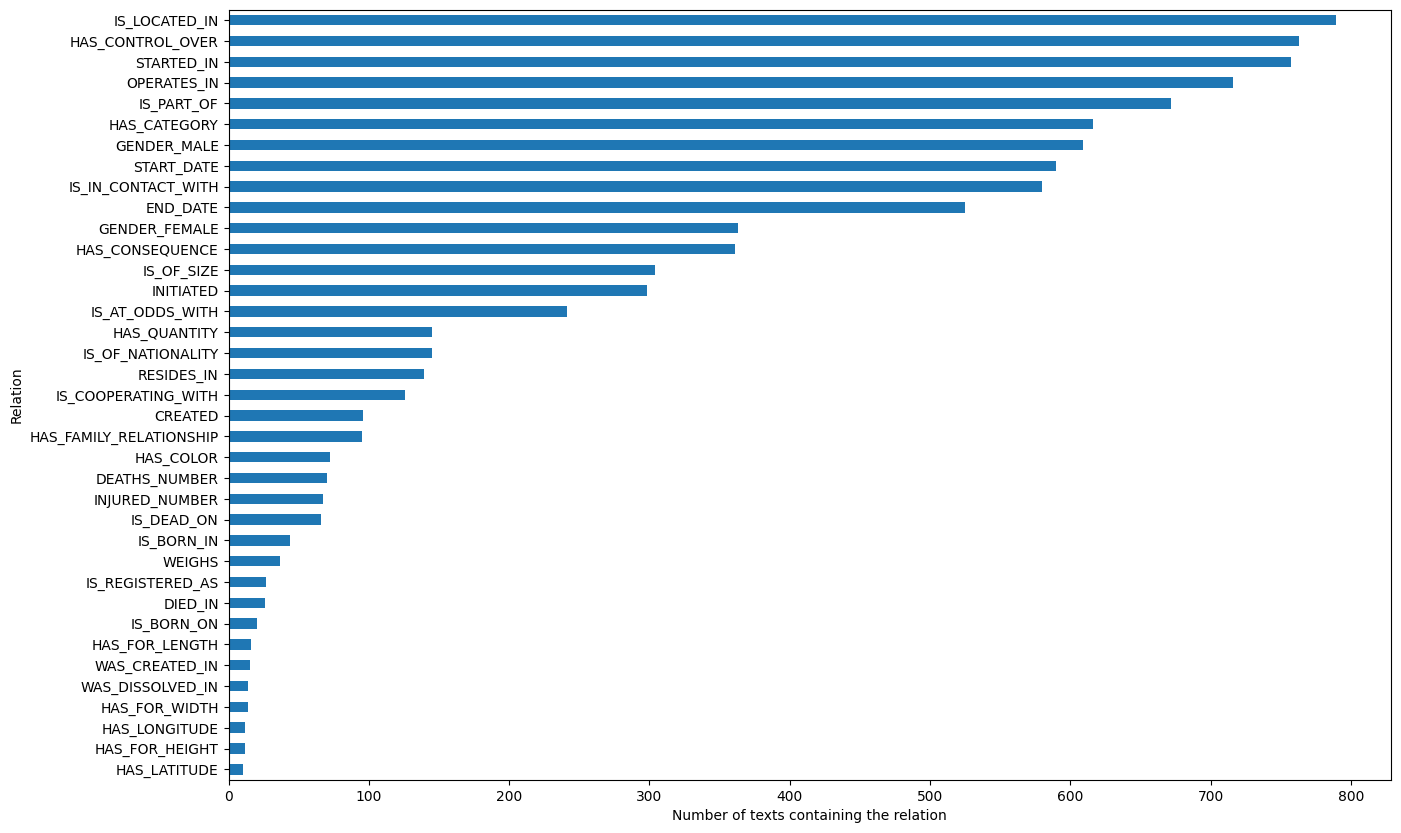

In [23]:
# number of text containing a relation category

plt.figure(figsize=(15, 10))
pd.Series({cat: labeled_raw_df[labeled_raw_df.relations.str.contains(cat)].shape[0] for cat in relation_classes}).sort_values(ascending=True).plot.barh(xlabel="Number of texts containing the relation", ylabel="Relation")

In [24]:
labeled_raw_df.relations.str.count("CREATED").sum()

141

In [25]:
# distribution of the occurences of each category among texts
pd.DataFrame({cat: labeled_raw_df.relations.str.count(cat) for cat in relation_classes}).describe().T.sort_values("50%", ascending=False)

,count,mean,std,min,25%,50%,75%,max
IS_LOCATED_IN,800.0,11.28125,6.555025,0.0,7.0,10.0,15.0,44.0
HAS_CONTROL_OVER,800.0,5.68375,3.724389,0.0,3.0,5.0,8.0,22.0
IS_IN_CONTACT_WITH,800.0,3.64875,4.583026,0.0,0.0,2.0,4.0,44.0
OPERATES_IN,800.0,3.04375,2.650588,0.0,1.0,2.0,4.0,19.0
STARTED_IN,800.0,2.32500,1.829223,0.0,1.0,2.0,3.0,12.0
GENDER_MALE,800.0,1.13500,0.864702,0.0,1.0,1.0,2.0,4.0
HAS_CATEGORY,800.0,1.11750,0.891452,0.0,1.0,1.0,2.0,5.0
IS_PART_OF,800.0,1.82750,1.642747,0.0,1.0,1.0,2.0,14.0
START_DATE,800.0,1.29250,1.165608,0.0,0.0,1.0,2.0,7.0
END_DATE,800.0,1.09250,1.081853,0.0,0.0,1.0,2.0,6.0


In [26]:
labeled_raw_df.relations.str.count("IS_LOCATED_IN")

id
181      17
31669    14
51470     5
51332     3
1131      8
         ..
1288     14
3822      6
51266     7
51368    13
124      23
Name: relations, Length: 800, dtype: int64

In [27]:
labeled_clean_df.relations.loc[181]

[[0, 'STARTED_IN', 9],
 [7, 'IS_LOCATED_IN', 9],
 [5, 'IS_LOCATED_IN', 10],
 [1, 'GENDER_FEMALE', 1],
 [12, 'IS_LOCATED_IN', 10],
 [0, 'IS_LOCATED_IN', 10],
 [1, 'IS_LOCATED_IN', 10],
 [13, 'IS_LOCATED_IN', 9],
 [14, 'IS_LOCATED_IN', 10],
 [1, 'HAS_CATEGORY', 18],
 [5, 'IS_LOCATED_IN', 9],
 [9, 'IS_LOCATED_IN', 10],
 [14, 'IS_DEAD_ON', 15],
 [7, 'HAS_CATEGORY', 19],
 [12, 'IS_LOCATED_IN', 9],
 [0, 'IS_LOCATED_IN', 9],
 [7, 'GENDER_MALE', 7],
 [11, 'IS_LOCATED_IN', 10],
 [1, 'IS_LOCATED_IN', 9],
 [14, 'IS_LOCATED_IN', 9],
 [14, 'HAS_CATEGORY', 20],
 [0, 'STARTED_IN', 10],
 [0, 'START_DATE', 15],
 [7, 'IS_LOCATED_IN', 10],
 [0, 'END_DATE', 15],
 [14, 'GENDER_MALE', 14],
 [12, 'IS_OF_SIZE', 22],
 [13, 'IS_LOCATED_IN', 10],
 [1, 'IS_LOCATED_IN', 11],
 [13, 'IS_OF_SIZE', 21]]

In [28]:
# Total occurences of each category in the labeled dataset
pd.Series({cat: labeled_raw_df.relations.str.count(cat).sum() for cat in relation_classes}).sort_values(ascending=False)

IS_LOCATED_IN              9025
HAS_CONTROL_OVER           4547
IS_IN_CONTACT_WITH         2919
OPERATES_IN                2435
STARTED_IN                 1860
IS_AT_ODDS_WITH            1526
IS_PART_OF                 1462
START_DATE                 1034
GENDER_MALE                 908
HAS_CATEGORY                894
END_DATE                    874
HAS_CONSEQUENCE             769
INITIATED                   469
IS_OF_SIZE                  438
GENDER_FEMALE               414
IS_COOPERATING_WITH         372
RESIDES_IN                  222
HAS_FAMILY_RELATIONSHIP     222
HAS_QUANTITY                191
IS_OF_NATIONALITY           179
CREATED                     141
HAS_COLOR                    91
DEATHS_NUMBER                75
INJURED_NUMBER               70
IS_DEAD_ON                   68
IS_BORN_IN                   50
DIED_IN                      41
WEIGHS                       41
IS_REGISTERED_AS             34
IS_BORN_ON                   20
HAS_FOR_LENGTH               16
WAS_CREA

<Axes: title={'center': 'Total occurences of each category in the labeled dataset'}, xlabel='Number of labeled relations of a given category', ylabel='Category of relation'>

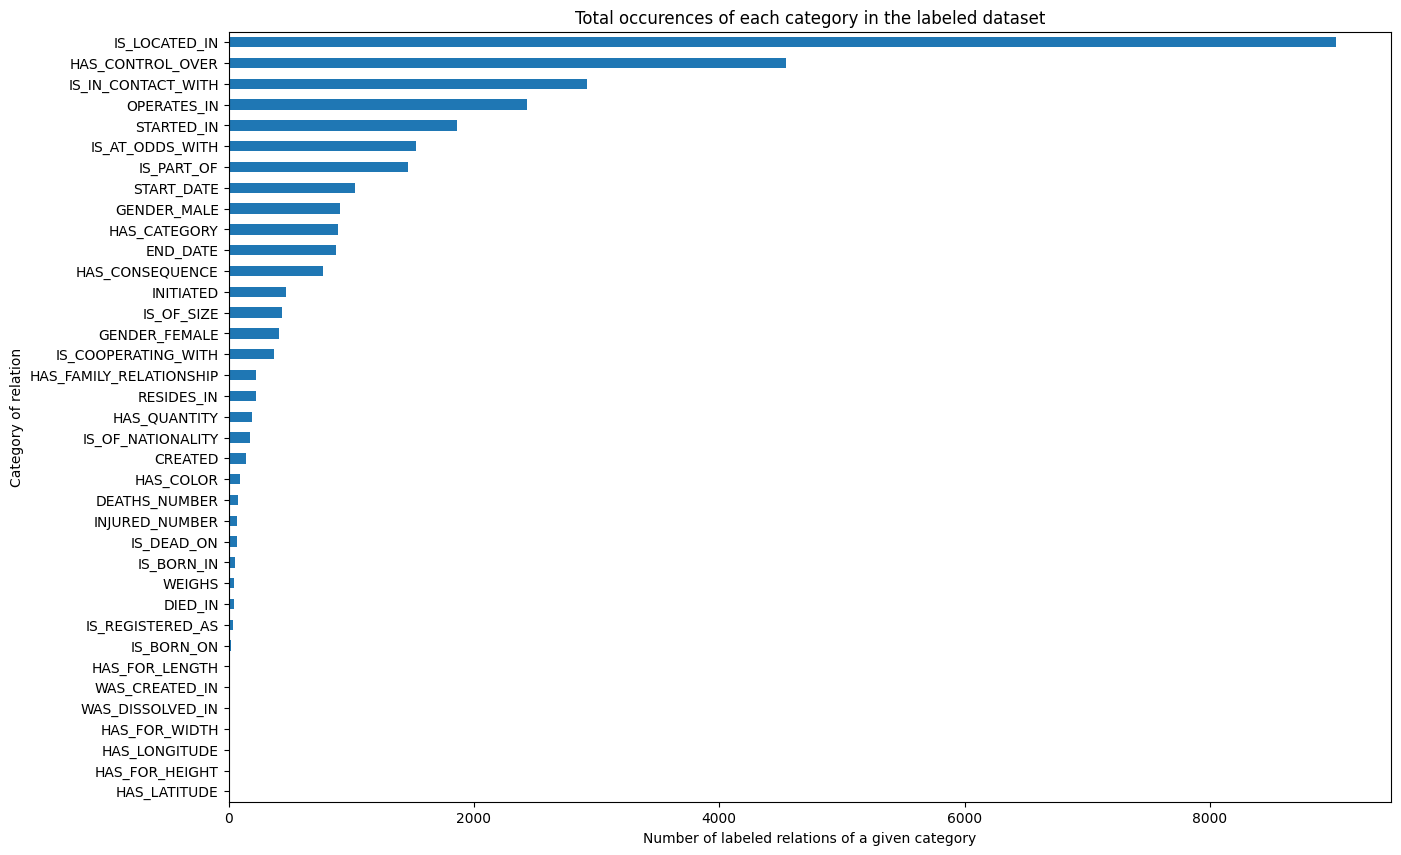

In [29]:
plt.figure(figsize=(15, 10))
pd.Series({cat: labeled_raw_df.relations.str.count(cat).sum() for cat in relation_classes}).sort_values(ascending=True).plot.barh(xlabel="Number of labeled relations of a given category", ylabel="Category of relation", title="Total occurences of each category in the labeled dataset")
# pd.Series({cat: labeled_raw_df.relations.str.count(cat).sum() for cat in relation_classes}).sort_values(ascending=False)

### Stats about the cooccurence between entity categories and relation categories

TODO: For each relation category:
- what is the number of time each entity category is e1?
- what is the number of time each entity category is e2?
- what pairs of entity categories are never into a relation?

In [30]:
labeled_clean_df.entities.loc[181]

[{'id': 0,
  'mentions': [{'value': 'accident', 'start': 70, 'end': 78},
   {'value': 'accident de circulation', 'start': 100, 'end': 123},
   {'value': 'accident', 'start': 275, 'end': 283}],
  'type': 'ACCIDENT'},
 {'id': 1,
  'mentions': [{'value': 'Anam Destresse', 'start': 0, 'end': 14},
   {'value': 'Anam Destresse', 'start': 431, 'end': 445}],
  'type': 'CIVILIAN'},
 {'id': 2,
  'mentions': [{'value': 'moto', 'start': 148, 'end': 152},
   {'value': 'moto', 'start': 550, 'end': 554}],
  'type': 'MATERIEL'},
 {'id': 3,
  'mentions': [{'value': 'bus', 'start': 159, 'end': 162},
   {'value': 'bus', 'start': 208, 'end': 211},
   {'value': 'bus', 'start': 589, 'end': 592}],
  'type': 'MATERIEL'},
 {'id': 4,
  'mentions': [{'value': 'panneaux de signalisation',
    'start': 289,
    'end': 314}],
  'type': 'MATERIEL'},
 {'id': 5,
  'mentions': [{'value': 'blessés', 'start': 470, 'end': 477}],
  'type': 'GROUP_OF_INDIVIDUALS'},
 {'id': 6,
  'mentions': [{'value': 'hélicoptère', 'start':

In [31]:
labeled_clean_df.relations.loc[181]

[[0, 'STARTED_IN', 9],
 [7, 'IS_LOCATED_IN', 9],
 [5, 'IS_LOCATED_IN', 10],
 [1, 'GENDER_FEMALE', 1],
 [12, 'IS_LOCATED_IN', 10],
 [0, 'IS_LOCATED_IN', 10],
 [1, 'IS_LOCATED_IN', 10],
 [13, 'IS_LOCATED_IN', 9],
 [14, 'IS_LOCATED_IN', 10],
 [1, 'HAS_CATEGORY', 18],
 [5, 'IS_LOCATED_IN', 9],
 [9, 'IS_LOCATED_IN', 10],
 [14, 'IS_DEAD_ON', 15],
 [7, 'HAS_CATEGORY', 19],
 [12, 'IS_LOCATED_IN', 9],
 [0, 'IS_LOCATED_IN', 9],
 [7, 'GENDER_MALE', 7],
 [11, 'IS_LOCATED_IN', 10],
 [1, 'IS_LOCATED_IN', 9],
 [14, 'IS_LOCATED_IN', 9],
 [14, 'HAS_CATEGORY', 20],
 [0, 'STARTED_IN', 10],
 [0, 'START_DATE', 15],
 [7, 'IS_LOCATED_IN', 10],
 [0, 'END_DATE', 15],
 [14, 'GENDER_MALE', 14],
 [12, 'IS_OF_SIZE', 22],
 [13, 'IS_LOCATED_IN', 10],
 [1, 'IS_LOCATED_IN', 11],
 [13, 'IS_OF_SIZE', 21]]

In [32]:
labeled_raw_df[labeled_raw_df.relations.str.contains("GENDER")]

,text,entities,relations
id,,,
181,"Anam Destresse, président de l'ONG ""Ma passion...","[{""id"": 0, ""mentions"": [{""value"": ""accident"", ...","[[0, ""STARTED_IN"", 9], [7, ""IS_LOCATED_IN"", 9]..."
31669,"À Paris, le 8 avril 2022, l'usine de déodorant...","[{""id"": 0, ""mentions"": [{""value"": ""explosé"", ""...","[[9, ""IS_LOCATED_IN"", 8], [11, ""OPERATES_IN"", ..."
51470,"En Espagne, dans une région agricole, une cont...","[{""id"": 0, ""mentions"": [{""value"": ""contaminati...","[[7, ""IS_PART_OF"", 8], [9, ""OPERATES_IN"", 1], ..."
51332,Un important incendie a fait des ravages dans ...,"[{""id"": 0, ""mentions"": [{""value"": ""incendie"", ...","[[12, ""IS_IN_CONTACT_WITH"", 5], [0, ""IS_LOCATE..."
1131,« Je coule » : onze heures après avoir envoyé ...,"[{""id"": 0, ""mentions"": [{""value"": ""renversé"", ...","[[9, ""IS_LOCATED_IN"", 2], [0, ""START_DATE"", 17..."
...,...,...,...
1288,"M. Thibault Alekseï, membre de l'association ""...","[{""id"": 0, ""mentions"": [{""value"": ""perdu le co...","[[2, ""IS_PART_OF"", 3], [12, ""IS_IN_CONTACT_WIT..."
3822,Des employés d'une usine de production médical...,"[{""id"": 0, ""mentions"": [{""value"": ""grève"", ""st...","[[8, ""HAS_CONTROL_OVER"", 7], [4, ""HAS_CATEGORY..."
51266,"Le 13 mars 2001, Belgrade a connu un krach bou...","[{""id"": 0, ""mentions"": [{""value"": ""krach bours...","[[1, ""STARTED_IN"", 3], [10, ""IS_PART_OF"", 4], ..."


### Text length

#### Number of chars

<Axes: >

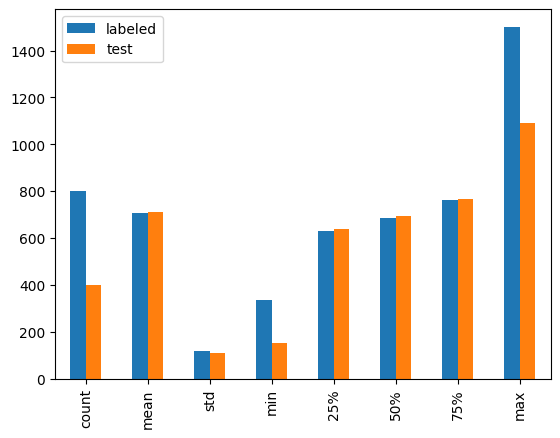

In [33]:
pd.DataFrame(
    {
        set_name: df.text.apply(len).describe()
        for set_name, df in zip(
            ["labeled", "test"],
            [labeled_clean_df, test_clean_df],
        )
    }
).plot.bar()

#### Number of tokens (subwords from CamemBERT tokenizer)

<Axes: >

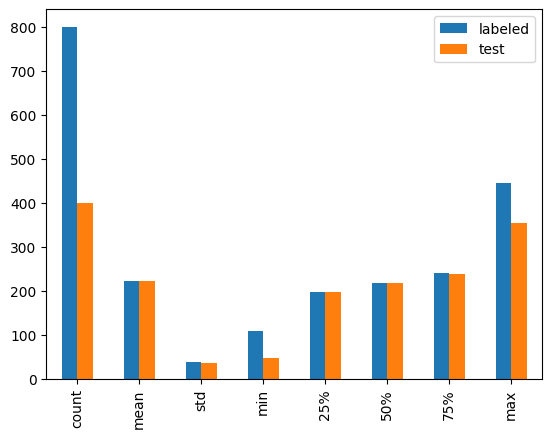

In [34]:
pd.DataFrame(
    {
        set_name: df.text.apply(count_tokens).describe()
        for set_name, df in zip(
            ["labeled", "test"],
            [labeled_clean_df, test_clean_df],
        )
    }
).plot.bar()

## Generate interim datasets

for each text, generate a csv file containing all the generated texts annotated as a multilabeled Text classification task

The csv file is named after the index of the text in the raw data


In [35]:
data_generator = TextToMultiLabelDataGenerator()
entity_pair_to_relations_df = data_generator.convert_relations_to_dataframe(labeled_clean_df.relations.loc[181])
entity_pair_to_relations_df

,e1,e2,relations
0,0,9,"[IS_LOCATED_IN, STARTED_IN]"
1,7,9,[IS_LOCATED_IN]
2,5,10,[IS_LOCATED_IN]
3,1,1,[GENDER_FEMALE]
4,12,10,[IS_LOCATED_IN]
5,0,10,"[IS_LOCATED_IN, STARTED_IN]"
6,1,10,[IS_LOCATED_IN]
7,13,9,[IS_LOCATED_IN]
8,14,10,[IS_LOCATED_IN]
9,1,18,[HAS_CATEGORY]


In [36]:
text_index = 181
text, text_entities, text_relations = labeled_clean_df.loc[text_index].to_list()
data_generator.tag_entities(text, text_entities[0], text_entities[9]).join(
            entity_pair_to_relations_df.set_index(
                [
                    "e1",
                    "e2",
                ]
            ),
            on=[
                "e1",
                "e2",
            ],
        )

,e1,e2,text,relations
0,0,9,"Anam Destresse, président de l'ONG ""Ma passion...","[IS_LOCATED_IN, STARTED_IN]"
1,9,0,"Anam Destresse, président de l'ONG ""Ma passion...",NaN


In [37]:
text_entities[0]

{'id': 0,
 'mentions': [{'value': 'accident', 'start': 70, 'end': 78},
  {'value': 'accident de circulation', 'start': 100, 'end': 123},
  {'value': 'accident', 'start': 275, 'end': 283}],
 'type': 'ACCIDENT'}

In [38]:
text_entities[9]

{'id': 9,
 'mentions': [{'value': 'autoroute de Saint-Marin', 'start': 169, 'end': 193}],
 'type': 'PLACE'}

In [39]:
data_generator.tag_all_possible_entity_pairs(text_index, text, text_entities).query("e1==0 and e2==9")

,text_index,e1,e2,text
82,181,0,9,"Anam Destresse, président de l'ONG ""Ma passion..."


In [40]:
text_index = 181
text, text_entities, text_relations = labeled_clean_df.loc[text_index].to_list()
mltc_df = data_generator.convert(text_index, text, text_entities, text_relations)
mltc_df

,text_index,e1,e2,text,relations
0,181,0,0,"Anam Destresse, président de l'ONG ""Ma passion...",NaN
1,181,1,0,"<e1><CIVILIAN>Anam Destresse</e1>, président d...",NaN
2,181,0,1,", président de l'ONG ""Ma passion"", a été bless...",NaN
3,181,1,1,"<e1><CIVILIAN>Anam Destresse</e1>, président d...",[GENDER_FEMALE]
4,181,2,0,"Anam Destresse, président de l'ONG ""Ma passion...",NaN
...,...,...,...,...,...
620,181,24,22,"Anam Destresse, président de l'ONG ""Ma passion...",NaN
621,181,22,24,"Anam Destresse, président de l'ONG ""Ma passion...",NaN
622,181,24,23,"Anam Destresse, président de l'ONG ""Ma passion...",NaN
623,181,23,24,"Anam Destresse, président de l'ONG ""Ma passion...",NaN


In [41]:
mltc_df.loc[84].text

'<e1><CIVILIAN>Anam Destresse</e1>, président de l\'ONG "Ma passion", a été blessé dans un accident. Le 30 juin 2022, un accident de circulation s\'est produit entre une moto et un bus sur l\' en Italie. Le bus, qui transportait 20 passagers, appartenait à l\'ONG. Lors de l\'accident, les panneaux de signalisation ont été complètement endommagés et le garde du corps a été blessé. Au total, deux passagers sont morts sur le coup. <e1><CIVILIAN>Anam Destresse</e1>, qui faisait partie des blessés, a été transporté en hélicoptère jusqu\'à l\'hôpital. Le conducteur de la moto a été retrouvé mort en dessous du bus. Il conduisait sans permis et en état d\'ivresse.'

In [43]:
mltc_df[~mltc_df.relations.isna()]

,text_index,e1,e2,text,relations
3,181,1,1,"<e1><CIVILIAN>Anam Destresse</e1>, président d...",[GENDER_FEMALE]
63,181,7,7,"Anam Destresse, président de l'ONG ""Ma passion...",[GENDER_MALE]
82,181,0,9,"Anam Destresse, président de l'ONG ""Ma passion...","[IS_LOCATED_IN, STARTED_IN]"
84,181,1,9,"<e1><CIVILIAN>Anam Destresse</e1>, président d...",[IS_LOCATED_IN]
92,181,5,9,"Anam Destresse, président de l'ONG ""Ma passion...",[IS_LOCATED_IN]
96,181,7,9,"Anam Destresse, président de l'ONG ""Ma passion...",[IS_LOCATED_IN]
101,181,0,10,"Anam Destresse, président de l'ONG ""Ma passion...","[IS_LOCATED_IN, STARTED_IN]"
103,181,1,10,"<e1><CIVILIAN>Anam Destresse</e1>, président d...",[IS_LOCATED_IN]
111,181,5,10,"Anam Destresse, président de l'ONG ""Ma passion...",[IS_LOCATED_IN]
115,181,7,10,"Anam Destresse, président de l'ONG ""Ma passion...",[IS_LOCATED_IN]


In [44]:
text = labeled_clean_df.text.loc[181]


In [45]:
generated_data_dir_path = os.path.join(INTERIM_DIR, "multilabel_tagged_text_dataset")
assert not os.path.exists(
    generated_data_dir_path
), f"You must delete this folder first {generated_data_dir_path}!"

data_generator = TextToMultiLabelDataGenerator()

for split_name, clean_df in zip(
    ["train", "test"],
    [labeled_clean_df, test_clean_df],
):
    dest_dir_path = os.path.join(generated_data_dir_path, split_name)
    for multilabel_data in (
        pb := tqdm(
            # data_generator.generate_row_multilabel_data(clean_df, only_w_relation=True if split_name!="test" else False),
            data_generator.generate_row_multilabel_data(clean_df, only_w_relation=False),
            total=clean_df.shape[0],
            desc=f"{dest_dir_path} <- ",
        )
    ):
        text_index = multilabel_data.iloc[0][data_generator.text_index_col]
        dest_csv_file = os.path.join(dest_dir_path, f"{text_index}.csv")
        pb.set_description(f"{dest_csv_file} <-")
        save_data(multilabel_data, dest_csv_file, False)
        # break
    # break
# multilabel_data

data/defi-text-mine-2025/interim/multilabel_tagged_text_dataset/train/124.csv <-: 100%|██████████| 800/800 [00:48<00:00, 16.57it/s]  
data/defi-text-mine-2025/interim/multilabel_tagged_text_dataset/test/51742.csv <-: 100%|██████████| 400/400 [00:22<00:00, 17.69it/s]


## Check tagged text size using a  data loader to load data from csv files

to know wether the will fit at the input of the model (i.e. max of 512 tokens)

##### add special tokens to the tokenizer

In [143]:
# define special tokens to add to the tokenizer
task_special_tokens = ["<e1>", "</e1>", "<e2>", "</e2>"] + [
    f"<{entity_class}>" for entity_class in entity_classes
]
# task_special_tokens

In [144]:
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

# add special tokens to the tokenizer
num_added_tokens = tokenizer.add_tokens(task_special_tokens, special_tokens=True)
num_added_tokens

/home/tagny/.pyenv/versions/3.11.8/envs/kgl11/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


59

In [145]:
tokenizer

BertTokenizerFast(name_or_path='bert-base-uncased', vocab_size=30522, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	30522: AddedToken("<e1>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	30523: AddedToken("</

### initialize the data loader

In [146]:
interim_dataset = load_dataset(
    "csv",
    name="multilabel_tagged_text_dataset",
    data_dir="data/defi-text-mine-2025/interim/multilabel_tagged_text_dataset/",
    streaming=False,
)

Resolving data files:   0%|          | 0/800 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/400 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

In [147]:
interim_dataset

DatasetDict({
    train: Dataset({
        features: ['text_index', 'e1', 'e2', 'text', 'relations'],
        num_rows: 26394
    })
    test: Dataset({
        features: ['text_index', 'e1', 'e2', 'text', 'relations'],
        num_rows: 182980
    })
})

In [148]:
interim_dataset["train"][0]

{'text_index': 11,
 'e1': 0,
 'e2': 1,
 'text': "Le 2 juillet 2022, un <e1><ACCIDENT>accident</e1> s'est produit entre une moto et un bus sur la  à Saint-Lô. Ce dernier transportait 30 passagers issus du syndicat de lutte contre le racisme. Un panneau de signalisation a été <e1><ACCIDENT>percuté</e1> et 2 personnes sont mortes sur le coup. Le Président du Syndicat, Monsieur Smith Aarone, était parmi les blessés. Il a immédiatement été transporté en hélicoptère à l'hôpital. Ayant conduit sans permis et en état d’ivresse, le conducteur de la moto a été retrouvé mort au bas d'un talus. Les journalistes sont ensuite arrivés sur le  avec leurs caméras, pour interroger les policiers sur les causes de l'<e1><ACCIDENT>accident</e1>.",
 'relations': "['IS_LOCATED_IN', 'STARTED_IN']"}

In [149]:
interim_dataset["train"][1]

{'text_index': 11,
 'e1': 0,
 'e2': 2,
 'text': "Le 2 juillet 2022, un <e1><ACCIDENT>accident</e1> s'est produit entre une moto et un bus sur la RN 174 à . Ce dernier transportait 30 passagers issus du syndicat de lutte contre le racisme. Un panneau de signalisation a été <e1><ACCIDENT>percuté</e1> et 2 personnes sont mortes sur le coup. Le Président du Syndicat, Monsieur Smith Aarone, était parmi les blessés. Il a immédiatement été transporté en hélicoptère à l'hôpital. Ayant conduit sans permis et en état d’ivresse, le conducteur de la moto a été retrouvé mort au bas d'un talus. Les journalistes sont ensuite arrivés sur le lieu avec leurs caméras, pour interroger les policiers sur les causes de l'<e1><ACCIDENT>accident</e1>.",
 'relations': "['IS_LOCATED_IN']"}

In [150]:
interim_dataset["test"][7]

{'text_index': 1102,
 'e1': 1,
 'e2': 2,
 'text': "Le 5 février 2022 à <e1><PLACE>Marseille</e1>, un  âgé de 35 ans est mort dans sa voiture après avoir percuté un bâtiment. Afin de minimiser les dégâts, des engins et des équipements spécialisés ont été utilisés pour retirer la voiture du bâtiment. Après constat, l'inspecteur Charles Laurent de la police scientifique a détecté la présence d'alcool et de drogue dans le sang du .  correspondait au signalement dans les avis de recherche de la police : . Il y a quelques jours, les habitants avaient remarqué un  ressemblant au , vêtu d'une chemise bleue et d'un pantalon noir, muni d'une arme à feu.",
 'relations': None}

### Count tokens

In [151]:
def count_token_in_dataset_element(example: Dict[str, Any]) -> Dict[str, int]:
    return {"n_tokens": count_tokens(example["text"])}


interim_dataset = interim_dataset.map(count_token_in_dataset_element)
interim_dataset

Map:   0%|          | 0/26394 [00:00<?, ? examples/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (530 > 512). Running this sequence through the model will result in indexing errors


Map:   0%|          | 0/182980 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text_index', 'e1', 'e2', 'text', 'relations', 'n_tokens'],
        num_rows: 26394
    })
    test: Dataset({
        features: ['text_index', 'e1', 'e2', 'text', 'relations', 'n_tokens'],
        num_rows: 182980
    })
})

In [152]:
split2ntokens_df = pd.DataFrame(
    {
        split_name: pd.Series(
            [e["n_tokens"] for e in tqdm(interim_dataset[split_name], split_name)],
            name=f"{split_name}_text_n_tokens",
        ).describe()
        for split_name in interim_dataset.keys()
    }
)
split2ntokens_df

test: 100%|██████████| 182980/182980 [00:04<00:00, 43903.57it/s]


,train,test
count,26394.000000,182980.000000
mean,245.150148,243.886048
std,64.923231,60.485125
min,104.000000,46.000000
25%,208.000000,208.000000
50%,229.000000,230.000000
75%,260.000000,261.000000
max,893.000000,713.000000


In [153]:
interim_dataset["train"][0]

{'text_index': 11,
 'e1': 0,
 'e2': 1,
 'text': "Le 2 juillet 2022, un <e1><ACCIDENT>accident</e1> s'est produit entre une moto et un bus sur la  à Saint-Lô. Ce dernier transportait 30 passagers issus du syndicat de lutte contre le racisme. Un panneau de signalisation a été <e1><ACCIDENT>percuté</e1> et 2 personnes sont mortes sur le coup. Le Président du Syndicat, Monsieur Smith Aarone, était parmi les blessés. Il a immédiatement été transporté en hélicoptère à l'hôpital. Ayant conduit sans permis et en état d’ivresse, le conducteur de la moto a été retrouvé mort au bas d'un talus. Les journalistes sont ensuite arrivés sur le  avec leurs caméras, pour interroger les policiers sur les causes de l'<e1><ACCIDENT>accident</e1>.",
 'relations': "['IS_LOCATED_IN', 'STARTED_IN']",
 'n_tokens': 199}